In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cnn_trainer.py to cnn_trainer.py
Saving imdb_test.csv to imdb_test.csv
Saving imdb_train.csv to imdb_train.csv
Saving shakespeare.txt to shakespeare.txt
User uploaded file "cnn_trainer.py" with length 12514 bytes
User uploaded file "imdb_test.csv" with length 6640779 bytes
User uploaded file "imdb_train.csv" with length 60197565 bytes
User uploaded file "shakespeare.txt" with length 1115394 bytes


In [ ]:
!wget https://people.cs.pitt.edu/~mzhang/cs1699/pacs_dataset.zip
!unzip pacs_dataset.zip
%rm pacs_dataset.zip

Motivation
-----------

AlexNet is a milestone in the resurgence of deep learning, and it astonished the computer vision community by winning the ILSVRC 2012 by a large margin.
In this assignment, you need to implement the original AlexNet using PyTorch. The model architecture is shown in the following figure, which is from their original [paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

> 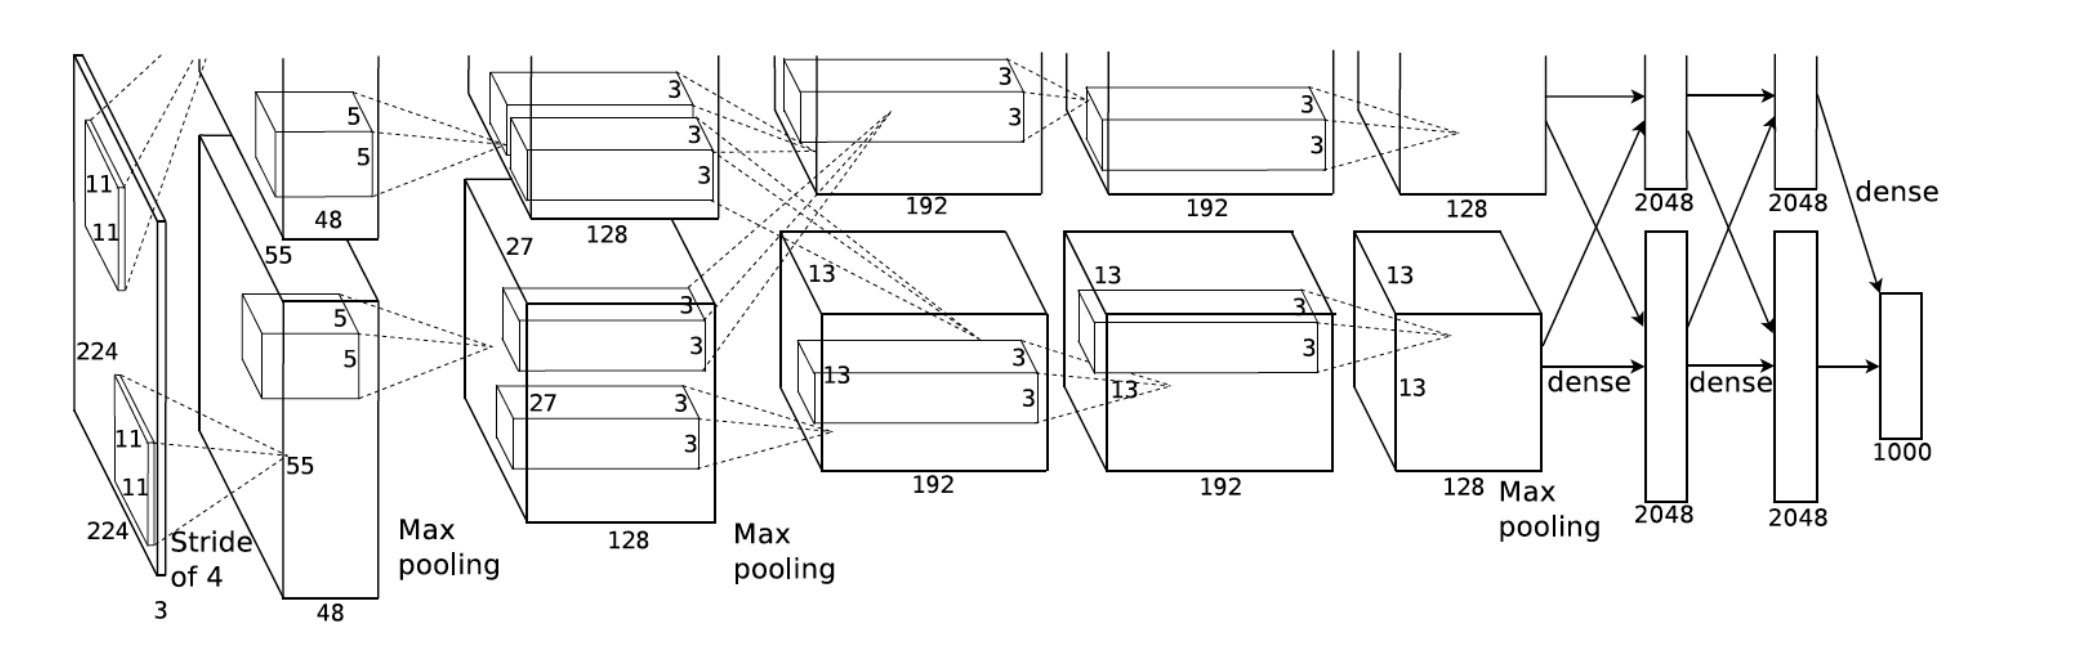

In [ ]:
# ---------------------
#  Model Architecture 
# ---------------------
# AlexNet(
#   (features): Sequential(
#     (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
#     (1): ReLU(inplace=True)
#     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
#     (4): ReLU(inplace=True)
#     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (7): ReLU(inplace=True)
#     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (9): ReLU(inplace=True)
#     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (11): ReLU(inplace=True)
#     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#   )
#   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
#   (classifier): Sequential(
#     (0): Dropout(p=0.5, inplace=False)
#     (1): Linear(in_features=9216, out_features=4096, bias=True)
#     (2): ReLU(inplace=True)
#     (3): Dropout(p=0.5, inplace=False)
#     (4): Linear(in_features=4096, out_features=4096, bias=True)
#     (5): ReLU(inplace=True)
#     (6): Linear(in_features=4096, out_features=4, bias=True)
#   )
# )

# ---------------------
# Validation Set Accuracy
# ---------------------
# [Epoch 15] eval accuracy: 0.9315, loss: 0.1770

In [ ]:
# complete training on domain class
!python cnn_trainer.py --task_type=training --label_type=domain --epochs=50 --learning_rate=0.0001 --weight_decay=0.0001 --batch_size=128 --experiment_name=demo

# complete training on category class
!python cnn_trainer.py --task_type=training --label_type=category --epochs=50 --learning_rate=0.0001 --weight_decay=0.0001 --batch_size=128 --experiment_name=demo

# Visualizing Learned Filters 

------------------------------------------

Different from hand-crafted features, the convolutional neural network extracted features from input images automatically thus are difficult for human to interpret. A useful strategy is to visualize the kernels learned from data. 

- Check the kernels learned in AlexNet for two different tasks, i.e. classifying domains or classes.
- Compare the kernels in different layers for two models (trained for two different tasks), and see if the kernels have different patterns.

In [ ]:
!python cnn_trainer.py --task_type=analysis --label_type=domain --epochs=1 --learning_rate=0.0001  --weight_decay=0.0001 --batch_size=128 --experiment_name=demo

Visualize the learned filter of `domain_0`
Visualize the learned filter of `category_0`
Visualize the learned filter of `domain_2`
Visualize the learned filter of `category_2`
Visualize the learned filter of `domain_4`
Visualize the learned filter of `category_4`
Visualize the learned filter of `domain_6`
Visualize the learned filter of `category_6`
Visualize the learned filter of `domain_8`
Visualize the learned filter of `category_8`


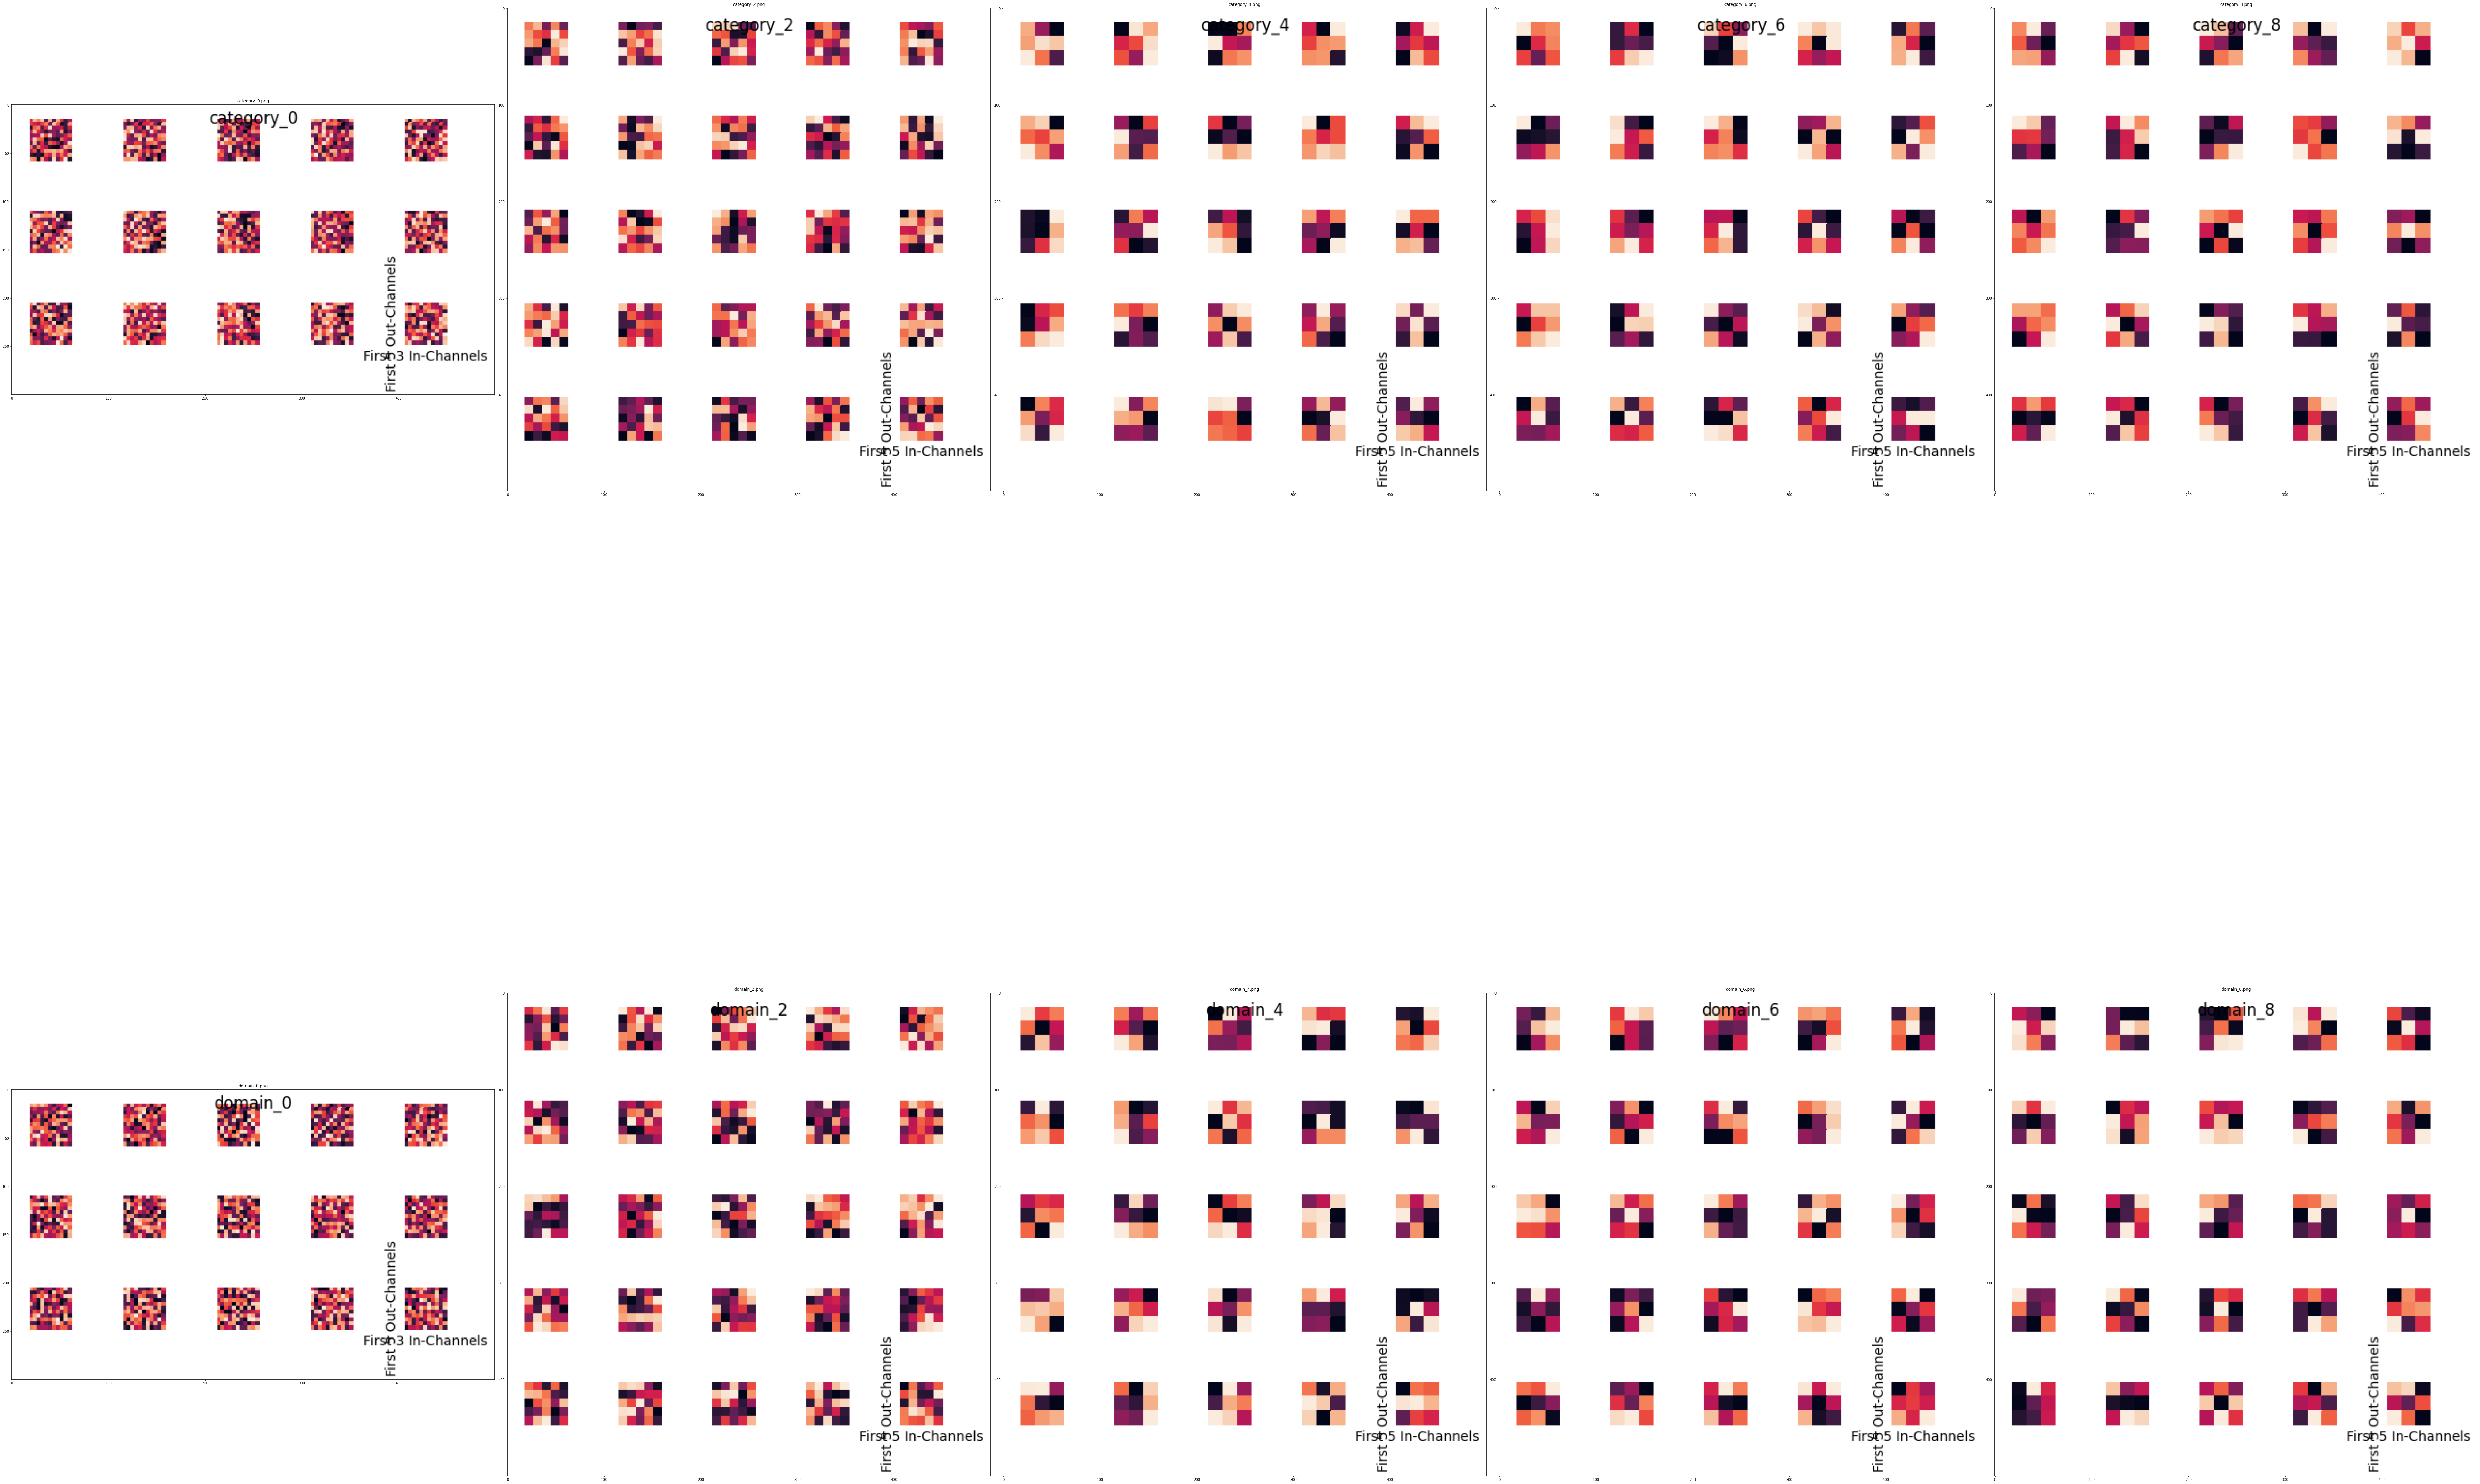

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(2, 5, figsize=(100,100))
images = os.listdir('kernel')
images.sort()

for i, image in enumerate(images):
  ax.ravel()[i].imshow(mpimg.imread(os.path.join('/content', 'kernel', image)))
  ax.ravel()[i].set_title(image)

plt.tight_layout()
plt.show()

# Comparison of kernels in different layers for two models (trained for two different tasks)
________________________________
As the model passes through more layers, the kernel contains larger pixels of a single color and the variation of the kernel changes at a lower rate. In other words, the model gains **confidence**. 

As you may expect, the learned weights of the two different models contain differnt kernels depending on the label type passed in. Simply put, this is because predicting image style vs contents are not the same task. 

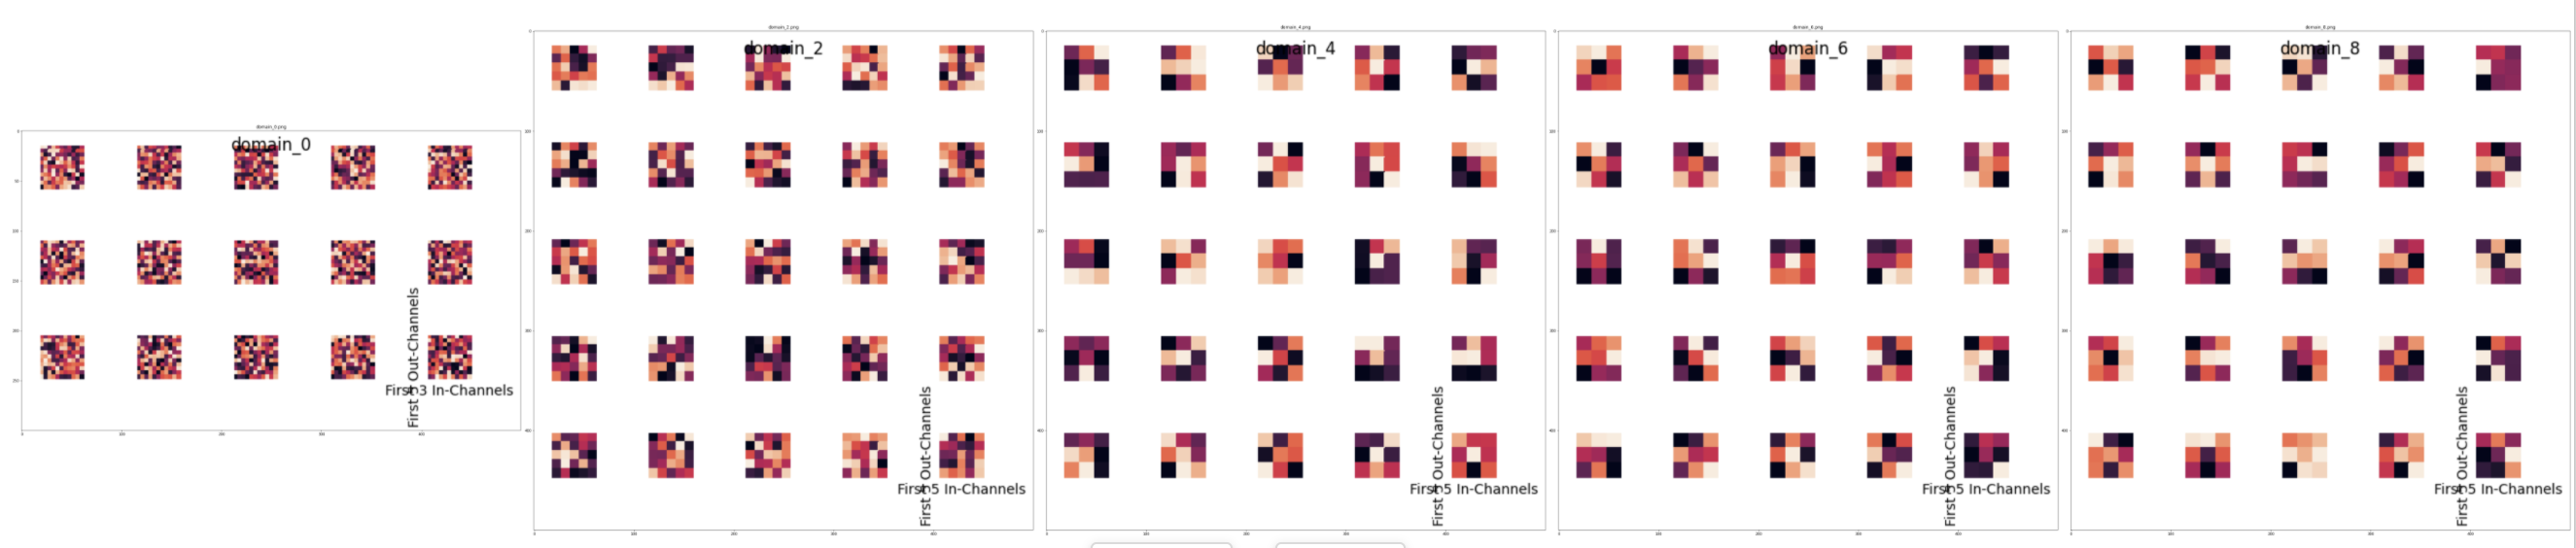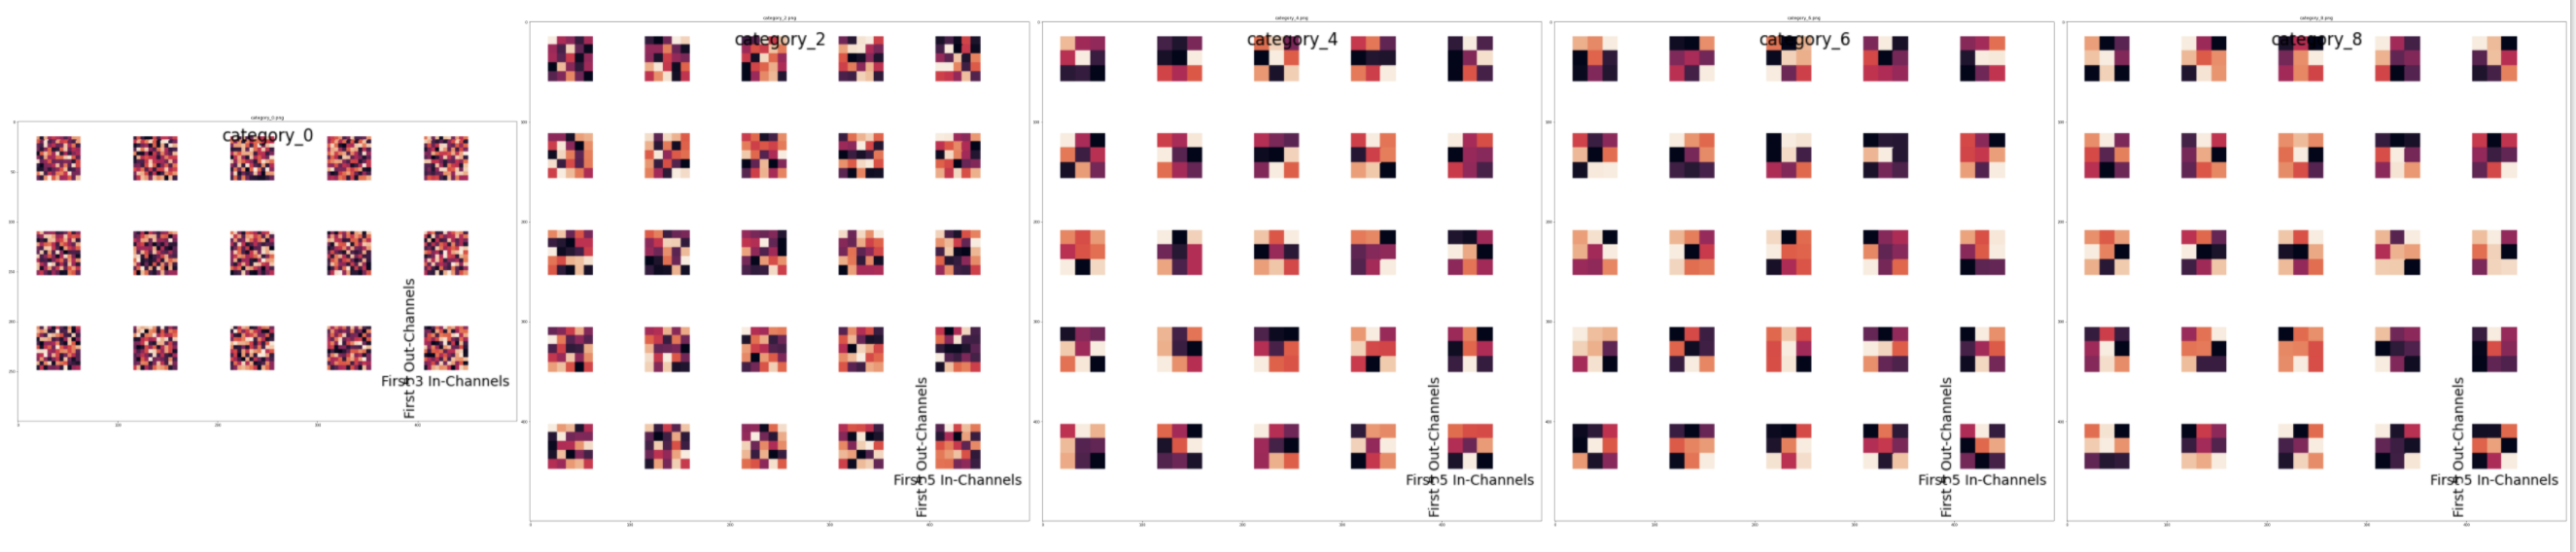

## Sentiment analysis on IMDB reviews

-----------------------------------
Large Moview Review Dataset (IMDB) is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. It provides a set of 50,000 highly polar movie reviews. We have split the dataset into training (45,000) and test (5,000). The positive:negative ratio is 1:1 in both splits.

In [3]:
import collections
import copy
import csv
import os
from io import StringIO

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.distributions import categorical
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm as tqdm
from google.colab import files
import matplotlib.pyplot as plt

In [4]:
train_dataset_text = uploaded['imdb_train.csv']
test_dataset_text = uploaded['imdb_test.csv']
shakespeare_text = uploaded['shakespeare.txt']

In [5]:
PADDING_TOKEN = 0

In [6]:
class GRUCell(nn.Module):
  """Implementation of GRU cell from https://arxiv.org/pdf/1406.1078.pdf."""

  def __init__(self, input_size, hidden_size, bias=False):
    super().__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    # Learnable weights and bias for `update gate`
    self.W_z = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
    if bias:
      self.b_z = nn.Parameter(torch.Tensor(hidden_size))
    else:
      self.register_parameter('b_z', None)

    # Learnable weights and bias for `reset gate`
    self.W_r = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
    if bias:
      self.b_r = nn.Parameter(torch.Tensor(hidden_size))
    else:
      self.register_parameter('b_r', None)

    # Learnable weights and bias for `output gate`
    self.W = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
    if bias:
      self.b = nn.Parameter(torch.Tensor(hidden_size))
    else:
      self.register_parameter('b', None)

    self.reset_parameters()

  def forward(self, x, prev_state):
    if prev_state is None:
      batch = x.shape[0]
      prev_h = torch.zeros((batch, self.hidden_size), device=x.device)
    else:
      prev_h = prev_state

    concat_hx = torch.cat((prev_h, x), dim=1)
    z = torch.sigmoid(F.linear(concat_hx, self.W_z, self.b_z))  # update 
    r = torch.sigmoid(F.linear(concat_hx, self.W_r, self.b_r))  # reset
    h_tilde = torch.tanh(
        F.linear(torch.cat((r * prev_h, x), dim=1), self.W, self.b))
    next_h = (1 - z) * prev_h + z * h_tilde
    return next_h

  def reset_parameters(self):
    sqrt_k = (1. / self.hidden_size)**0.5
    with torch.no_grad():
      for param in self.parameters():
        param.uniform_(-sqrt_k, sqrt_k)
    return

  def extra_repr(self):
    return 'input_size={}, hidden_size={}, bias={}'.format(
        self.input_size, self.hidden_size, self.bias is not True)

  def count_parameters(self):
    print('Total Parameters: %d' %
          sum(p.numel() for p in self.parameters() if p.requires_grad))
    return

In [8]:
class LSTMCell(nn.Module):

  def __init__(self, input_size, hidden_size, bias=False):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    # Learnable weights and bias for `input gate`
    self.W_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
    if bias:
      self.b_i = nn.Parameter(torch.Tensor(hidden_size))
    else:
      self.register_parameter('b_i', None)

    # Learnable weights and bias for `forget gate`
    self.W_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
    if bias:
      self.b_f = nn.Parameter(torch.Tensor(hidden_size))
    else:
      self.register_parameter('b_f', None)
    
    # Learnable weights and bias for `cell memory`
    self.W_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
    if bias:
      self.b_c = nn.Parameter(torch.Tensor(hidden_size))
    else:
      self.register_parameter('b_c', None)
    
    # Learnable weights and bias for `output gate`
    self.W_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
    if bias:
      self.b_o = nn.Parameter(torch.Tensor(hidden_size))
    else:
      self.register_parameter('b_o', None)
      
    self.reset_parameters()

  def forward(self, x, prev_state):
    if prev_state is None:
      batch = x.shape[0]
      prev_h = torch.zeros((batch, self.hidden_size), device=x.device)
      prev_c = torch.zeros((batch, self.hidden_size), device=x.device)
    else:
      prev_h, prev_c = prev_state[0], prev_state[1]

    concat_hx = torch.cat((prev_h, x), dim=1)

    # forget gate layer
    # -----------------
    # decide what information we’re going to throw away from the cell state
    # looks at ht−1 and xt, and outputs a number between 0 and 1 for each number in the cell state Ct−1
    f_t = torch.sigmoid(F.linear(concat_hx, self.W_f, self.b_f))

    # input gate layer
    # -----------------
    # decides which values we’ll update
    i_t = torch.sigmoid(F.linear(concat_hx, self.W_i, self.b_i))

    # cell memory gate layer
    # -----------------
    # creates a vector of new candidate values, C̃ t, that could be added to the state.
    c_t = torch.tanh(F.linear(concat_hx, self.W_c, self.b_c))

    # update cell state
    # Multiply the old state by ft, forgetting the things we decided to forget earlier.
    # add to the new candidate values, scaled by how much we decided to update each state value.
    next_c = (f_t * prev_c) + (i_t * c_t)

    # output gate layer
    # -----------------
    # filtered version of cell state.
    # the sigmoid layer decides what parts of the cell state we’re going to output
    o = torch.sigmoid(F.linear(concat_hx, self.W_o, self.b_o))

    # this reduces the output to only the parts we want
    next_h = o * torch.tanh(next_c)

    return next_h, next_c
  
  def reset_parameters(self):
    sqrt_k = (1. / self.hidden_size)**0.5
    with torch.no_grad():
      for param in self.parameters():
        param.uniform_(-sqrt_k, sqrt_k)
    return

  def extra_repr(self):
    return 'input_size={}, hidden_size={}, bias={}'.format(
        self.input_size, self.hidden_size, self.bias is not True)

  def count_parameters(self):
    print('Total Parameters: %d' %
          sum(p.numel() for p in self.parameters() if p.requires_grad))
    return

In [9]:
RNN_MODULES = {
  'gru': GRUCell,
  'lstm': LSTMCell,
}

In [10]:
class IMDBReviewDataset(Dataset):

  def __init__(self,
               csv_text,
               vocabulary=None,
               vocab_min_count=10,
               vocab_max_size=None,
               review_max_length=200):
    self.csv_text = csv_text
    self.vocab_min_count = vocab_min_count
    self.vocab_max_size = vocab_max_size
    self.review_max_length = review_max_length - 2

    self.data = []

    encoded_text = csv_text.strip().decode(encoding='utf-8')
    fp = StringIO(encoded_text)
    reader = csv.DictReader(fp, delimiter=',')
    for row in tqdm(reader):
      self.data.append((row['review'].split(' ')[:review_max_length],
                        int(row['sentiment'] == 'positive')))
    fp.close()

    if vocabulary is not None:
      print('Using external vocabulary - vocab-related configs ignored.')
      self.vocabulary = vocabulary
    else:
      self.vocabulary = self._build_vocabulary()

    self.word2index = {w: i for (i, w) in enumerate(self.vocabulary)}
    self.index2word = {i: w for (i, w) in enumerate(self.vocabulary)}
    self.oov_token_id = self.word2index['OOV_TOKEN']
    self.pad_token_id = self.word2index['PAD_TOKEN']

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    review, label = self.data[index]
    review = ['BEGIN_TOKEN'] + review + ['END_TOKEN']
    token_ids = [self.word2index.get(w, self.oov_token_id) for w in review]
    return token_ids, label

  def _build_vocabulary(self):
    special_tokens = ['PAD_TOKEN', 'BEGIN_TOKEN', 'OOV_TOKEN', 'END_TOKEN']

    counter = collections.Counter()
    for review, _ in self.data:
      counter.update(review)

    vocab = counter.most_common(self.vocab_max_size - 4)
    if self.vocab_min_count is not None:
      vocab_tokens = [w for (w, c) in vocab if c >= self.vocab_min_count]
    else:
      vocab_tokens, _ = zip(vocab)

    return special_tokens + vocab_tokens

  def get_vocabulary(self):
    return self.vocabulary

  def print_statistics(self):
    reviews, labels = zip(*self.data)
    lengths = [len(x) for x in reviews]
    positive = np.sum(labels)
    negative = len(labels) - positive
    print('Total instances: %d, positive: %d, negative: %d' %
          (len(self.data), positive, negative))
    print('Review lengths: max: %d, min: %d, mean: %d, median: %d' %
          (max(lengths), min(lengths), np.mean(lengths), np.median(lengths)))
    print('Vocabulary size: %d' % len(self.vocabulary))
    return


def imdb_collate_fn(batch_data, padding_token_id=PADDING_TOKEN):
  """Padding variable-length sequences."""
  batch_tokens, batch_labels = zip(*batch_data)
  lengths = [len(x) for x in batch_tokens]
  max_length = max(lengths)

  padded_tokens = []
  for tokens, length in zip(batch_tokens, lengths):
    padded_tokens.append(tokens + [padding_token_id] * (max_length - length))

  padded_tokens = torch.tensor(padded_tokens, dtype=torch.int64)
  lengths = torch.tensor(lengths, dtype=torch.int64)
  labels = torch.tensor(batch_labels, dtype=torch.int64)

  return padded_tokens, lengths, labels

In [11]:
class SentimentClassification(nn.Module):

  def __init__(self,
               vocabulary_size,
               embedding_dim,
               rnn_module,
               hidden_size,
               bias=True):
    super().__init__()
    self.vocabulary_size = vocabulary_size
    self.rnn_module = rnn_module
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.bias = bias

    self.embedding = nn.Embedding(num_embeddings=vocabulary_size,
                                  embedding_dim=embedding_dim,
                                  padding_idx=PADDING_TOKEN)
    self.rnn_model = self.rnn_module(input_size=embedding_dim,
                                     hidden_size=hidden_size,
                                     bias=bias)
    self.classifier = nn.Linear(hidden_size, 2)
    return

  def forward(self, batch_reviews, batch_lengths):
    data = self.embedding(batch_reviews)

    state = None
    batch_size, total_steps, _ = data.shape
    full_outputs = []
    for step in range(total_steps):
      next_state = self.rnn_model(data[:, step, :], state)
      if isinstance(next_state, tuple):
        h, c = next_state
        full_outputs.append(h)
      else:
        full_outputs.append(next_state)
      state = next_state
    
    full_outputs = torch.stack(full_outputs, dim=1)
    outputs = full_outputs[torch.arange(batch_size), batch_lengths - 1, :]
    logits = self.classifier(outputs)
    return logits

In [12]:
def imdb_trainer(batch_size, epochs):
  train_dataset = IMDBReviewDataset(csv_text=train_dataset_text,
                                    vocab_min_count=VOCABULARY_MIN_COUNT,
                                    vocab_max_size=VOCABULARY_MAX_SIZE,
                                    review_max_length=REVIEW_MAX_LENGTH)
  train_dataset.print_statistics()
  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=8,
                            collate_fn=imdb_collate_fn)
  vocabulary = train_dataset.get_vocabulary()

  # Validation dataset should use the same vocabulary as the training set.
  val_dataset = IMDBReviewDataset(csv_text=test_dataset_text,
                                  vocabulary=vocabulary,
                                  review_max_length=REVIEW_MAX_LENGTH)
  val_dataset.print_statistics()
  val_loader = DataLoader(val_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=8,
                          collate_fn=imdb_collate_fn)

  best_model = None
  best_acc = 0.0

  full_train_loss = []
  full_train_accuracy = []
  full_val_loss = []
  full_val_accuracy = []

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  model = SentimentClassification(vocabulary_size=len(vocabulary),
                                  embedding_dim=EMBEDDING_DIM,
                                  rnn_module=RNN_MODULES[RNN_MODULE],
                                  hidden_size=HIDDEN_SIZE)
  model.to(device)

  model.rnn_model.count_parameters()

  print('Model Architecture:\n%s' % model)

  criterion = nn.CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=LEARNING_RATE,
                               weight_decay=WEIGHT_DECAY)

  for epoch in range(epochs):
    for phase in ('train', 'eval'):
      if phase == 'train':
        model.train()
        dataset = train_dataset
        data_loader = train_loader
      else:
        model.eval()
        dataset = val_dataset
        data_loader = val_loader

      running_loss = 0.0
      running_corrects = 0

      for step, (reviews, lengths, labels) in tqdm(enumerate(data_loader)):
        reviews = reviews.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(reviews, lengths)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()

            # RNN model is easily getting exploded gradients, thus we perform
            # gradients clipping to mitigate this issue.
            nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_NORM)
            optimizer.step()

        running_loss += loss.item() * reviews.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataset)
      epoch_acc = running_corrects.double() / len(dataset)
      if phase == 'train': 
        full_train_accuracy.append(epoch_acc)
        full_train_loss.append(epoch_loss)
      elif phase == 'eval':
        full_val_accuracy.append(epoch_acc)
        full_val_loss.append(epoch_loss)
      
      print('[Epoch %d] %s accuracy: %.4f, loss: %.4f' %
            (epoch + 1, phase, epoch_acc, epoch_loss))

      if phase == 'eval':
        if epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model = copy.deepcopy(model.state_dict())
      
  state_dict = {"model": best_model,
                "vocabulary": vocabulary}
  print("Best validation accuracy: %.4f" % best_acc)
  logs = (full_train_loss, full_train_accuracy, full_val_loss, full_val_accuracy)

  return state_dict, logs

In [14]:
### Hyperparameters for training
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
BATCH_SIZE = 4096
EPOCHS = 5
GRADIENT_CLIP_NORM = 1.0

### Hyperparameters for sentence analysis model
EMBEDDING_DIM = 128
HIDDEN_SIZE = 100
REVIEW_MAX_LENGTH = 200
VOCABULARY_MIN_COUNT = 100
VOCABULARY_MAX_SIZE = 20000
RNN_MODULE = 'gru'    # try 'lstm' and 'gru'

In [15]:
state_dict, logs = imdb_trainer(BATCH_SIZE, EPOCHS)


Total instances: 45000, positive: 22500, negative: 22500
Review lengths: max: 200, min: 8, mean: 168, median: 198
Vocabulary size: 4835


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Using external vocabulary - vocab-related configs ignored.
Total instances: 5000, positive: 2500, negative: 2500
Review lengths: max: 200, min: 11, mean: 167, median: 195
Vocabulary size: 4835
Total Parameters: 68700
Model Architecture:
SentimentClassification(
  (embedding): Embedding(4835, 128, padding_idx=0)
  (rnn_model): GRUCell(input_size=128, hidden_size=100, bias=False)
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)



[Epoch 1] train accuracy: 0.5101, loss: 0.6965



[Epoch 1] eval accuracy: 0.5178, loss: 0.6905
Best validation accuracy: 0.5178


In [ ]:
def plot_info(logs):
  full_train_loss = logs[0]
  full_train_accuracy = [float(i) for i in logs[1]]
  full_val_accuracy = [float(i) for i in logs[3]]

  fig, ax = plt.subplots(1, 3, figsize=(20, 10))

  ax[0].scatter(list(range(0, len(full_train_loss))), full_train_loss)
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Training loss')
  ax[0].set_title('Epoch vs Training loss')

  ax[1].scatter(list(range(0, len(full_train_accuracy))), full_train_accuracy)
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Training accuracy')
  ax[1].set_title('Epoch vs Training accuracy')

  ax[2].scatter(list(range(0, len(full_val_accuracy))), full_val_accuracy)
  ax[2].set_xlabel('Epoch')
  ax[2].set_ylabel('Validation accuracy')
  ax[2].set_title('Epoch vs Validation accuracy')
  plt.show()

plot_info(logs)

Analysis of LSTM and GRU
-------------------------

Below are two figures, containing graphs for two different models. Both are Recurrent Nueral Networks (RNNs), however one contains an LSTM cell while the other contains a GRU cell. The graphs depict various statistics during the training of both models.



> Based off the graphs, the model with the LSTM cell learns at a quicker rate. This may be due to the parameter discrepency between the between the two cells. While the GRU cell contains 69,700 model parameters, the LSTM contains 91,600. Therefore the LSTM has more information in the earlier stages and has a better **initial** model performance. The GRU however reaches slightly better results overall. For the GRU, the validation accuracy reaches ~85% during the last 4 epochs. For the LSTM however, it is much less consistent and ranges between 80 - 85% during the last 5 epochs.




RNN with GRU
------------
> 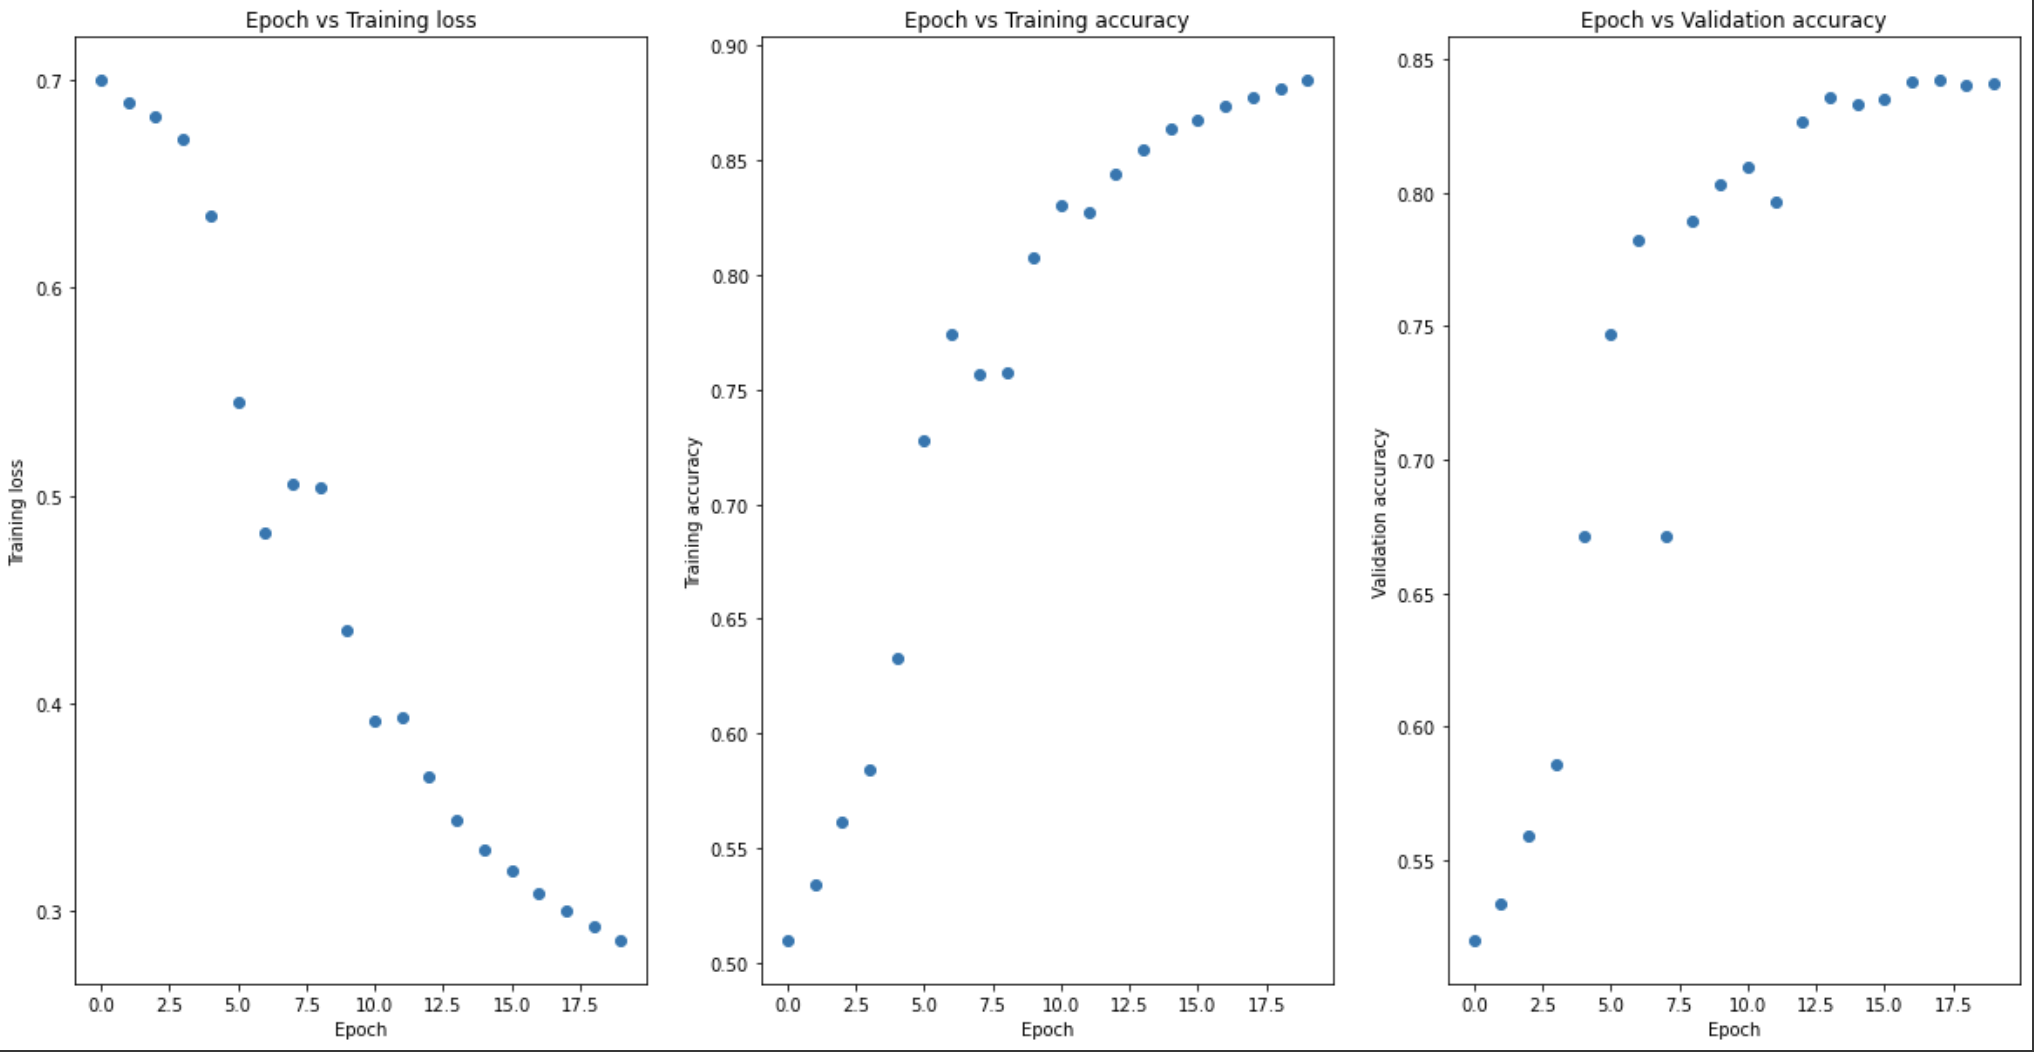

RNN with LSTM
---------------
> 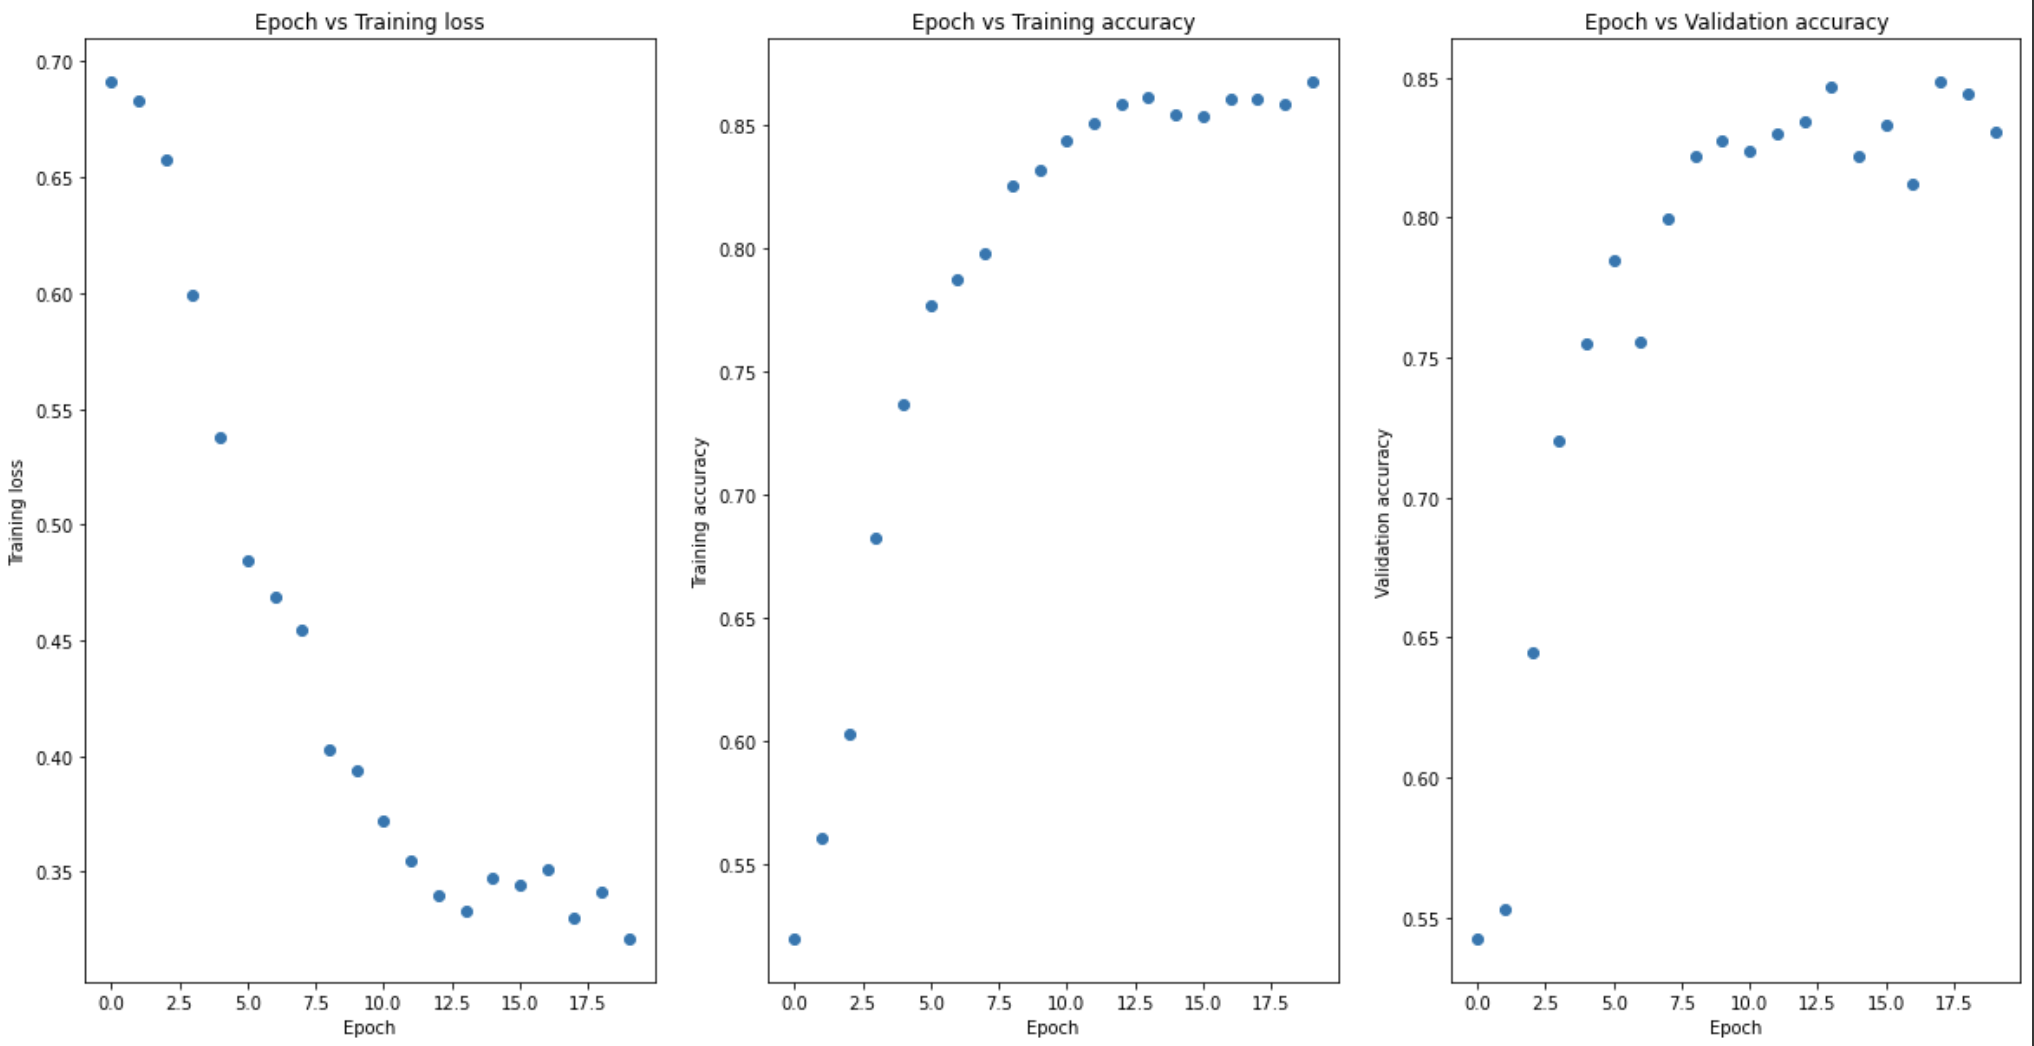

GRU
---------
> 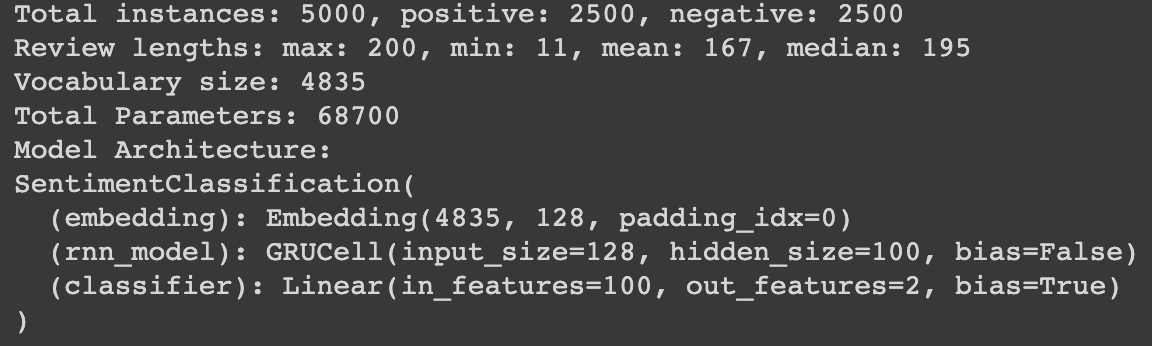

LSTM
---------
> 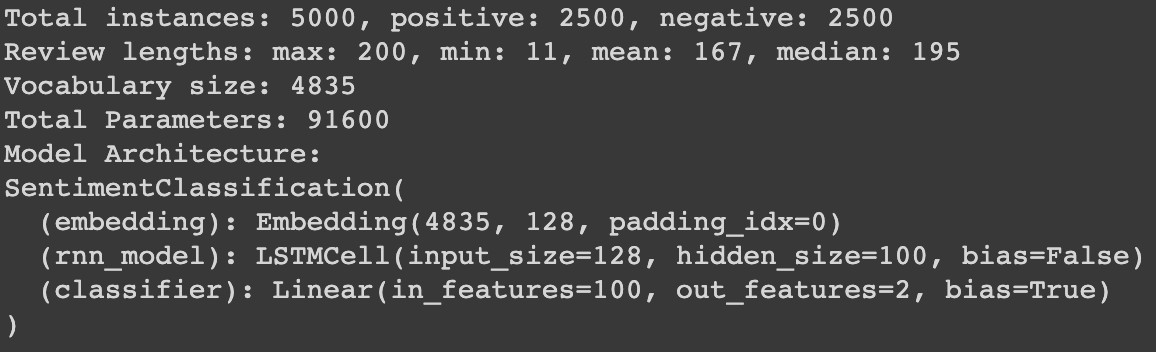

# Shakespeare Writer (Language model and sentence generation)

A character-based RNN model (meaning instead of words, RNN processed one character at a time) to learn how to write like Shakespeare.


In [32]:
### Hyperparameters for training (previously defined in FLAGS)
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
BATCH_SIZE = 4096
EPOCHS = 5

### Hyperparameters for sentence analysis model
EMBEDDING_DIM = 256
HIDDEN_SIZE = 512
RNN_MODULE = 'gru'
HISTORY_LENGTH = 100

### Hyperparameters for generating new sentence
GENERATION_LENGTH = 1000
START_STRING = 'JULIET'
TEMPERATURE = 1.0

In [33]:
class ShakespeareDataset(Dataset):

  def __init__(self, encoded_text, history_length):
    self.encoded_text = encoded_text
    self.history_length = history_length

    raw_text = self.encoded_text.strip().decode(encoding='utf-8')

    self.vocab = sorted(set(raw_text))
    self.char2index = {x: i for (i, x) in enumerate(self.vocab)}
    self.index2char = {i: x for (i, x) in enumerate(self.vocab)}

    self.data = [(raw_text[i:i + history_length], raw_text[i + history_length])
                 for i in range(len(raw_text) - history_length)]
    return

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    history, label = self.data[index]
    history = np.array([self.char2index[x] for x in history])
    label = self.char2index[label]
    return history, label

  def get_vocabulary(self):
    return self.vocab

In [19]:
class SentenceGeneration(nn.Module):

  def __init__(self,
               vocabulary_size,
               embedding_dim,
               rnn_module,
               hidden_size,
               bias=False):
    super().__init__()
    self.vocabulary_size = vocabulary_size
    self.rnn_module = rnn_module
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.bias = bias

    self.embedding = nn.Embedding(num_embeddings=vocabulary_size,
                                  embedding_dim=embedding_dim,
                                  padding_idx=PADDING_TOKEN)
    self.rnn_model = self.rnn_module(input_size=embedding_dim,
                                     hidden_size=hidden_size,
                                     bias=bias)
    self.classifier = nn.Linear(hidden_size, vocabulary_size)
    return

  def forward(self, batch_reviews, state=None):
    data = self.embedding(batch_reviews)

    batch_size, total_steps, _ = data.shape
    for step in range(total_steps):
      next_state = self.rnn_model(data[:, step, :], state)
      if isinstance(next_state, tuple):
        h, c = next_state
        outputs = h
      else:
        outputs = next_state
      state = next_state

    logits = self.classifier(outputs)
    return logits, state

  def reset_parameters(self):
    with torch.no_grad:
      for param in self.parameters():
        param.reset_parameters()
    return

In [20]:
def shakespeare_trainer(batch_size, epochs):
  train_dataset = ShakespeareDataset(encoded_text=shakespeare_text,
                                     history_length=HISTORY_LENGTH)
  
  print('Train dataset: %d' % len(train_dataset))

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=8)
  vocabulary = train_dataset.get_vocabulary()

  best_model = None
  best_loss = 0.0
  full_loss = []

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  model = SentenceGeneration(vocabulary_size=len(vocabulary),
                             embedding_dim=EMBEDDING_DIM,
                             rnn_module=RNN_MODULES[RNN_MODULE],
                             hidden_size=HIDDEN_SIZE)
  model.to(device)

  print('Model Architecture:\n%s' % model)

  criterion = nn.CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  for epoch in range(epochs):
    model.train()
    dataset = train_dataset
    data_loader = train_loader

    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (sequences, labels) in progress_bar:
      total_step = epoch * len(data_loader) + step
      sequences = sequences.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs, _ = model(sequences)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      corrects = torch.sum(preds == labels.data)

      loss.backward()
      optimizer.step()

      progress_bar.set_description(
          'Loss: %.4f, Accuracy: %.4f' %
          (loss.item(), corrects.item() / len(labels)))
      full_loss.append(loss.item())

  state_dict = {"model": model.cpu().state_dict(),
                "vocabulary": vocabulary}
                 
  return state_dict, full_loss

In [21]:
final_model, loss = shakespeare_trainer(batch_size=BATCH_SIZE,
                                        epochs=EPOCHS)

Train dataset: 1115293
Model Architecture:
SentenceGeneration(
  (embedding): Embedding(65, 256, padding_idx=0)
  (rnn_model): GRUCell(input_size=256, hidden_size=512, bias=True)
  (classifier): Linear(in_features=512, out_features=65, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
def sample_next_char_id(predicted_logits):
  next_char_id = categorical.Categorical(logits=predicted_logits).sample()
  return next_char_id

In [25]:
def shakespeare_writer(state_dict, start_string):
  """Generates new sentences using trained language model."""
  device = 'cpu'

  vocabulary = state_dict['vocabulary']

  char2index = {x: i for (i, x) in enumerate(vocabulary)}
  index2char = {i: x for (i, x) in enumerate(vocabulary)}

  inputs = torch.tensor([char2index[x] for x in start_string])
  inputs = inputs.view(1, -1)

  model = SentenceGeneration(vocabulary_size=len(vocabulary),
                             embedding_dim=EMBEDDING_DIM,
                             rnn_module=RNN_MODULES[RNN_MODULE],
                             hidden_size=HIDDEN_SIZE)

  model.load_state_dict(state_dict['model'])
  model.eval()

  generated_chars = []

  for step in range(GENERATION_LENGTH):
    logits, state = model.forward(inputs)
    next_idx = sample_next_char_id(logits)
    next_char = index2char[int(next_idx)]
    next_idx = torch.reshape(next_idx, (-1,1))  # change to 2-d
    generated_chars.append(next_char)

    # update history sequence 
    inputs = torch.cat((inputs, next_idx), 1)
    
  return start_string + ''.join(generated_chars)

In [31]:
generated_text = shakespeare_writer(final_model, START_STRING)
print(generated_text)

JULIET:
Of the beed joy of mest his off!

CISARTES:
For poctwards for imporriagion.

ARTERY:
So your waste


Evaulation of Shakespeare Writer
--------------------------------

I evaluated the model by setting the first string (history) to ROMEO and JULIET. I used the GRU cell for the RNN for this test and terminated the model once it wrote a total of 1000 characters. Note that the model learns how to spell each word and write the sentence-like paragraphs all by itself, even including the punctuations and line breaks. 

The results are shown Below. 

In [26]:
# ROMEO:
# We could it be you are of that scarce a saw.

# ESCALUS:
# Ay, where pelcome by the duke, counsel:
# This well's briable: the say my lifes,
# Srial that had turn'd wish Northumberland;'
# Their part jozets that believes: this discontented heart?

# MERCUTIO:
# Ay, weary, mild noble Cockingman:
# The pooces in heavy book, I kneel him a hook,
# Do prove the house of mercy
# Iathated in thy hate, and takened it
# Look in provoking their accordinant convearibally,
# With pluck souls mine, such all them again,
# Whose fair joy infadoms, favour in thy pence
# Of great blows is book the deadly cheels,
# Their hearing words did you migself, or he
# That his another of which willingness
# Tusgain, let Flantay'd 'tis to your triumph!

# ISABELLA:
# You have through the royal brands much soldiers to
# She seem the Duke of Winch the otherward kept and dreath:
# The pray on thy royally of all flight?
# If she is unkils, to expect gentleman in my charge.
# Come it boy to thither.
# A refix'd so knowledge. God sir, since I must be?
# Since I have 

# --------------------------------------------

# JULIET:
# O Kates, that the Earl of Norfolk the people,
# That where in thee not for the king's lady. With the king;
# Who dies me over are is the mair more abodity?
# Being queen to you, slew, let me be lay
# Till I have a bold withsilinunes did impossure
# For their body prevent me Aufidius:
# And that I then knew the scorn by assail it with prepetion,
# We think more flarious old regard, would acknow.
# Thy boy, and see her late, for a lawful
# good morrow! what, shows may leave thee show you;
# In banish'd am a hope, reepry the free
# The revertion be sly, to prove, thou must kissed
# They mourn'd bring to exact to be princely,
# It is five up the Capitolous savened forsolves.
# Here, sir, brother, Tyrrel:
# So sir, God know my rest? I am like's?
# Whatiness that my royal tyrant?
# No, then set of this restities what we had a little confend;
# Against those the teech honour lark, book,
# Which well all of bieted fingers
# that doth rebels' pretty young holy father?

# KING HENRY VI:
# I do you speak; and your help is apprey to York: